
# ACCT445 Data Exploration: Bank Disclosure Opacity & Stock Returns

**Research Question**: Do banks with opaque CECL disclosures (high CNOI) underperform their more transparent peers?

**Data Sources**
- CNOI scores for 40 banks (top/bottom cohorts) from `config/sample_cnoi.csv`
- Historical equity prices sourced via Yahoo Finance (`yfinance`) through `src.utils.market_data`
- Filing metadata plus SEC CIK → ticker mapping

**Hypothesis**
> Higher CNOI (more opaque) should correlate with weaker forward returns and noisier volatility profiles.


## 1. Environment Setup

In [1]:

from __future__ import annotations

import sys
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

PROJECT_ROOT = Path().resolve()
if not (PROJECT_ROOT / "config").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent

if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

from src.data.cik_ticker_mapper import enrich_cnoi_with_tickers
from src.utils.data_loader import load_cnoi_data
from src.utils.market_data import fetch_bulk_data, validate_data_quality
from src.utils.validation import validate_cnoi_schema
from src.utils.logger import get_logger

sns.set_theme(style="whitegrid")
pd.options.display.float_format = "{:.4f}".format

LOGGER = get_logger("notebooks.data_exploration")

CNOI_PATH = PROJECT_ROOT / "config" / "sample_cnoi.csv"
RESULTS_DIR = PROJECT_ROOT / "results"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

MARKET_START = "2023-01-01"
MARKET_END = pd.Timestamp.today().strftime("%Y-%m-%d")


## 2. Load & Validate CNOI Data

In [2]:

cnoi_df = load_cnoi_data(str(CNOI_PATH))
validate_cnoi_schema(cnoi_df)

dimension_cols = ["D", "G", "R", "J", "T", "S", "X"]
LOGGER.info(
    "Loaded %s filings from %s issuers spanning %s → %s",
    len(cnoi_df),
    cnoi_df["issuer"].nunique(),
    cnoi_df["filing_date"].min().date(),
    cnoi_df["filing_date"].max().date(),
)

cnoi_df.head()


2025-11-08 16:09:52 - src.utils.validation - INFO - CNOI schema validation passed (411 rows).


2025-11-08 16:09:52 - src.utils.data_loader - INFO - Loaded 411 CNOI rows from /Users/nirvanchitnis/ACCT445-Showcase/config/sample_cnoi.csv


2025-11-08 16:09:52 - src.utils.validation - INFO - CNOI schema validation passed (411 rows).


2025-11-08 16:09:52 - notebooks.data_exploration - INFO - Loaded 411 filings from 40 issuers spanning 2023-02-10 → 2025-10-29


,cik,accession,form,filing_date,is_pbe,issuer,score,CNOI,D,G,...,X,penalty_reasons,ixbrl_has_vintage,ixbrl_has_credit_quality,ixbrl_has_rollforward,ixbrl_has_aging,ixbrl_custom_only,heading_selected_title,heading_selected_score,quarter
0,846617,0000846617-23-000018,10-K,2023-02-28,False,"Dime Community Bancshares, Inc. /NY/",13.4800,13.4800,8.0000,30.0000,...,25.0000,D:heavy_cross_refs|G:missing_aging|G:missing_c...,False,False,False,False,NaN,Table of Contents determined based upon the ou...,18.6400,2023Q1
1,846617,0000846617-23-000040,10-Q,2023-05-08,False,"Dime Community Bancshares, Inc. /NY/",8.9500,8.9500,0.0000,20.0000,...,15.0000,G:missing_aging|G:missing_rollforward|J:high_r...,False,False,False,False,NaN,Table of Contents Selected Financial Highlight...,20.6900,2023Q2
2,846617,0000846617-23-000059,10-Q,2023-08-02,False,"Dime Community Bancshares, Inc. /NY/",10.4700,10.4700,4.0000,20.0000,...,15.0000,D:heavy_cross_refs|G:missing_aging|G:missing_r...,False,False,False,False,NaN,Table of Contents Allowance for Off-Balance Sh...,18.8900,2023Q3
3,846617,0000846617-23-000084,10-Q,2023-11-02,False,"Dime Community Bancshares, Inc. /NY/",8.8700,8.8700,4.0000,12.0000,...,15.0000,D:heavy_cross_refs|G:missing_rollforward|S:dam...,False,False,False,False,NaN,Table of Contents Accruing Loans 90 Days or Mo...,20.6200,2023Q4
4,846617,0000846617-24-000018,10-K,2024-02-22,False,"Dime Community Bancshares, Inc. /NY/",10.3300,10.3300,8.0000,8.0000,...,15.0000,D:heavy_cross_refs|G:missing_aging|J:high_read...,False,False,False,False,NaN,Table of Contents Past Due Loans Loans Delinqu...,19.2400,2024Q1


In [3]:

summary_stats = cnoi_df["CNOI"].describe().to_frame(name="CNOI_distribution")
dimension_stats = cnoi_df[dimension_cols].describe().transpose()[["mean", "std", "min", "max"]]

display(summary_stats)
display(dimension_stats)


,CNOI_distribution
count,411.0000
mean,18.0274
std,5.1208
min,5.5600
25%,14.6700
50%,18.4900
75%,21.6250
max,43.3000


,mean,std,min,max
D,2.9213,5.1643,0.0000,42.1700
G,25.1582,7.9463,0.0000,50.0000
R,14.2214,13.0572,0.0000,80.0000
J,18.4885,10.2877,0.0000,70.2700
T,32.7007,11.7445,0.0000,55.0000
S,22.1280,20.0379,0.0000,80.0000
X,22.3552,6.0595,0.0000,33.0000


## 3. Score Distribution & Outliers

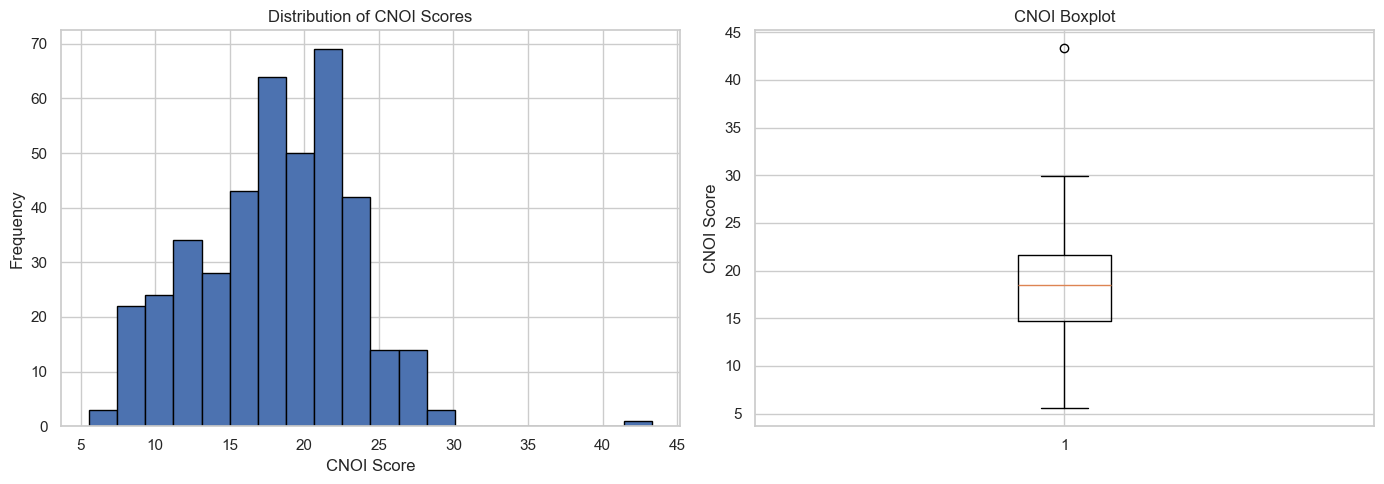

In [4]:

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(cnoi_df["CNOI"], bins=20, edgecolor="black")
axes[0].set_xlabel("CNOI Score")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Distribution of CNOI Scores")

axes[1].boxplot(cnoi_df["CNOI"], vert=True)
axes[1].set_ylabel("CNOI Score")
axes[1].set_title("CNOI Boxplot")

plt.tight_layout()
plt.show()


## 4. Transparency Rankings

In [5]:

issuer_scores = cnoi_df.groupby("issuer")["CNOI"].mean().sort_values()
top_transparent = issuer_scores.head(10).reset_index(name="avg_cnoi")
top_opaque = issuer_scores.tail(10).sort_values(ascending=False).reset_index(name="avg_cnoi")

display(top_transparent.style.set_caption("Most Transparent Banks (Low CNOI)"))
display(top_opaque.style.set_caption("Most Opaque Banks (High CNOI)"))


,issuer,avg_cnoi
0,"COMMUNITY FINANCIAL SYSTEM, INC.",9.555455
1,AMERISERV FINANCIAL INC /PA/,9.811818
2,CAPITAL ONE FINANCIAL CORP,11.047273
3,FIRST UNITED CORP/MD/,11.732727
4,"Dime Community Bancshares, Inc. /NY/",12.078182
5,FIRST COMMONWEALTH FINANCIAL CORP /PA/,12.573636
6,CITY HOLDING CO,13.342727
7,FIDELITY D & D BANCORP INC,14.711818
8,Bank First Corp,14.992727
9,FIRST OF LONG ISLAND CORP,17.146000


,issuer,avg_cnoi
0,ENB Financial Corp,24.341818
1,FULTON FINANCIAL CORP,23.539091
2,GUARANTY BANCSHARES INC /TX/,22.970000
3,HSBC USA INC /MD/,22.767500
4,HOPE BANCORP INC,22.418182
5,FARMERS & MERCHANTS BANCORP,22.344545
6,Burke & Herbert Financial Services Corp.,21.723000
7,COMMUNITY BANCORP /VT,21.481818
8,CF BANKSHARES INC.,21.466364
9,"Carter Bankshares, Inc.",21.260000


## 5. Dimension Correlations

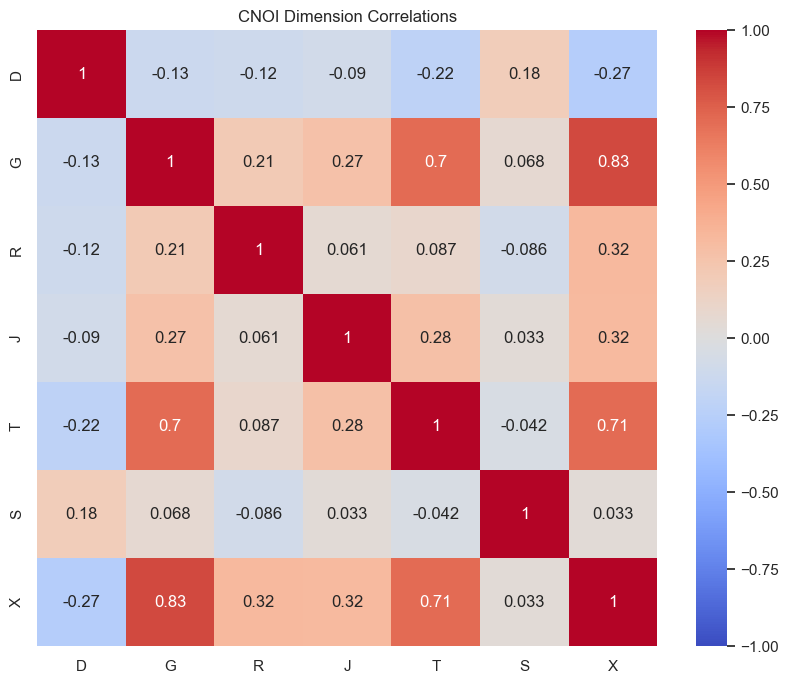

In [6]:

corr_matrix = cnoi_df[dimension_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="coolwarm",
    center=0,
    vmin=-1,
    vmax=1,
)
plt.title("CNOI Dimension Correlations")
plt.show()


## 6. CNOI Trends Over Time

/var/folders/c2/rc42yxvx009dr4hwd0tv71zc0000gn/T/ipykernel_90440/780521422.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(trend["quarter"].astype(str), rotation=45, ha="right")


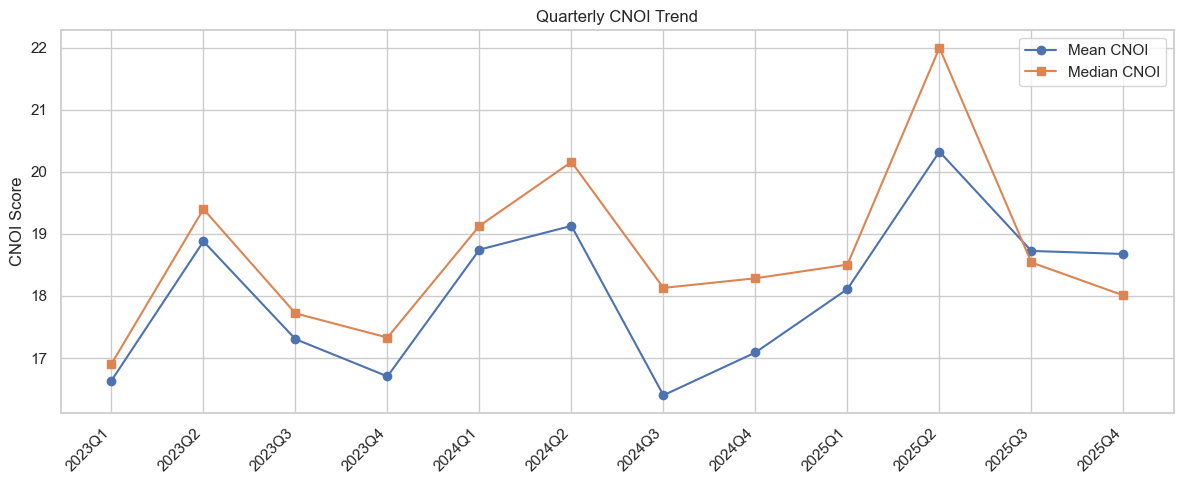

,quarter,mean,median,count
0,2023Q1,16.6362,16.9050,34
1,2023Q2,18.8800,19.4000,36
2,2023Q3,17.3041,17.7200,39
3,2023Q4,16.7043,17.3300,37
4,2024Q1,18.7468,19.1300,37
5,2024Q2,19.1295,20.1600,37
6,2024Q3,16.3997,18.1300,36
7,2024Q4,17.0892,18.2850,38
8,2025Q1,18.1113,18.5050,38
9,2025Q2,20.3256,22.0000,39


In [7]:

trend = (
    cnoi_df.assign(quarter=cnoi_df["filing_date"].dt.to_period("Q"))
    .groupby("quarter")["CNOI"]
    .agg(["mean", "median", "count"])
    .reset_index()
)

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(trend["quarter"].astype(str), trend["mean"], marker="o", label="Mean CNOI")
ax.plot(trend["quarter"].astype(str), trend["median"], marker="s", label="Median CNOI")
ax.set_xticklabels(trend["quarter"].astype(str), rotation=45, ha="right")
ax.set_ylabel("CNOI Score")
ax.set_title("Quarterly CNOI Trend")
ax.legend()
plt.tight_layout()
plt.show()

trend


## 7. Enrich with SEC Tickers

In [8]:

cnoi_df = enrich_cnoi_with_tickers(cnoi_df)
ticker_coverage = cnoi_df["ticker"].notna().mean() * 100
LOGGER.info("Ticker coverage: %.1f%%", ticker_coverage)

cnoi_df.head()


2025-11-08 16:09:53 - src.data.cik_ticker_mapper - INFO - Fetching SEC ticker mapping via cached client


2025-11-08 16:09:53 - src.data.sec_api_client - INFO - Loading SEC mapping from cache (age: 0.6h)


2025-11-08 16:09:53 - src.data.cik_ticker_mapper - INFO - Fetched 7900 company ticker mappings


2025-11-08 16:09:53 - src.data.cik_ticker_mapper - INFO - Loaded 4 manual CIK overrides from /Users/nirvanchitnis/ACCT445-Showcase/config/cik_ticker_overrides.csv


2025-11-08 16:09:53 - src.data.cik_ticker_mapper - INFO - Applied 29 manual ticker overrides.


2025-11-08 16:09:53 - notebooks.data_exploration - INFO - Ticker coverage: 100.0%


,cik,accession,form,filing_date,is_pbe,issuer,score,CNOI,D,G,...,ixbrl_has_credit_quality,ixbrl_has_rollforward,ixbrl_has_aging,ixbrl_custom_only,heading_selected_title,heading_selected_score,quarter,ticker,company_name,notes
0,846617,0000846617-23-000018,10-K,2023-02-28,False,"Dime Community Bancshares, Inc. /NY/",13.4800,13.4800,8.0000,30.0000,...,False,False,False,NaN,Table of Contents determined based upon the ou...,18.6400,2023Q1,DCOMG,"Dime Community Bancshares, Inc. /NY/",NaN
1,846617,0000846617-23-000040,10-Q,2023-05-08,False,"Dime Community Bancshares, Inc. /NY/",8.9500,8.9500,0.0000,20.0000,...,False,False,False,NaN,Table of Contents Selected Financial Highlight...,20.6900,2023Q2,DCOMG,"Dime Community Bancshares, Inc. /NY/",NaN
2,846617,0000846617-23-000059,10-Q,2023-08-02,False,"Dime Community Bancshares, Inc. /NY/",10.4700,10.4700,4.0000,20.0000,...,False,False,False,NaN,Table of Contents Allowance for Off-Balance Sh...,18.8900,2023Q3,DCOMG,"Dime Community Bancshares, Inc. /NY/",NaN
3,846617,0000846617-23-000084,10-Q,2023-11-02,False,"Dime Community Bancshares, Inc. /NY/",8.8700,8.8700,4.0000,12.0000,...,False,False,False,NaN,Table of Contents Accruing Loans 90 Days or Mo...,20.6200,2023Q4,DCOMG,"Dime Community Bancshares, Inc. /NY/",NaN
4,846617,0000846617-24-000018,10-K,2024-02-22,False,"Dime Community Bancshares, Inc. /NY/",10.3300,10.3300,8.0000,8.0000,...,False,False,False,NaN,Table of Contents Past Due Loans Loans Delinqu...,19.2400,2024Q1,DCOMG,"Dime Community Bancshares, Inc. /NY/",NaN


## 8. Fetch Market Data via yfinance

In [9]:

unique_tickers = sorted(cnoi_df["ticker"].dropna().unique())
LOGGER.info(
    "Fetching market data for %s tickers between %s and %s",
    len(unique_tickers),
    MARKET_START,
    MARKET_END,
)

market_df = fetch_bulk_data(
    unique_tickers,
    start_date=MARKET_START,
    end_date=MARKET_END,
    use_cache=True,
)

market_df.head()


2025-11-08 16:09:53 - notebooks.data_exploration - INFO - Fetching market data for 40 tickers between 2023-01-01 and 2025-11-08


2025-11-08 16:09:53 - src.utils.market_data - INFO - Loaded ALRS from cache (716 rows).


2025-11-08 16:09:53 - src.utils.market_data - INFO - Progress: 1/40 tickers processed.


2025-11-08 16:09:53 - src.utils.market_data - INFO - Loaded AROW from cache (716 rows).


2025-11-08 16:09:53 - src.utils.market_data - INFO - Progress: 2/40 tickers processed.


2025-11-08 16:09:54 - src.utils.market_data - INFO - Loaded ASRV from cache (716 rows).


2025-11-08 16:09:54 - src.utils.market_data - INFO - Progress: 3/40 tickers processed.


2025-11-08 16:09:54 - src.utils.market_data - INFO - Loaded BANC-PF from cache (486 rows).


2025-11-08 16:09:54 - src.utils.market_data - INFO - Progress: 4/40 tickers processed.


2025-11-08 16:09:55 - src.utils.market_data - INFO - Loaded BCAL from cache (716 rows).


2025-11-08 16:09:55 - src.utils.market_data - INFO - Progress: 5/40 tickers processed.


2025-11-08 16:09:55 - src.utils.market_data - INFO - Loaded BFC from cache (716 rows).


2025-11-08 16:09:55 - src.utils.market_data - INFO - Progress: 6/40 tickers processed.


2025-11-08 16:09:56 - src.utils.market_data - INFO - Loaded BHRB from cache (716 rows).


2025-11-08 16:09:56 - src.utils.market_data - INFO - Progress: 7/40 tickers processed.


2025-11-08 16:09:56 - src.utils.market_data - INFO - Loaded BOKF from cache (716 rows).


2025-11-08 16:09:56 - src.utils.market_data - INFO - Progress: 8/40 tickers processed.


2025-11-08 16:09:57 - src.utils.market_data - INFO - Loaded C-PN from cache (716 rows).


2025-11-08 16:09:57 - src.utils.market_data - INFO - Progress: 9/40 tickers processed.


2025-11-08 16:09:57 - src.utils.market_data - INFO - Loaded CARE from cache (716 rows).


2025-11-08 16:09:57 - src.utils.market_data - INFO - Progress: 10/40 tickers processed.


2025-11-08 16:09:58 - src.utils.market_data - INFO - Loaded CBKM from cache (716 rows).


2025-11-08 16:09:58 - src.utils.market_data - INFO - Progress: 11/40 tickers processed.


2025-11-08 16:09:58 - src.utils.market_data - INFO - Loaded CBNA from cache (275 rows).


2025-11-08 16:09:58 - src.utils.market_data - INFO - Progress: 12/40 tickers processed.


2025-11-08 16:09:59 - src.utils.market_data - INFO - Loaded CBNK from cache (716 rows).


2025-11-08 16:09:59 - src.utils.market_data - INFO - Progress: 13/40 tickers processed.


2025-11-08 16:09:59 - src.utils.market_data - INFO - Loaded CBU from cache (716 rows).


2025-11-08 16:09:59 - src.utils.market_data - INFO - Progress: 14/40 tickers processed.


2025-11-08 16:10:00 - src.utils.market_data - INFO - Loaded CFBK from cache (716 rows).


2025-11-08 16:10:00 - src.utils.market_data - INFO - Progress: 15/40 tickers processed.


2025-11-08 16:10:00 - src.utils.market_data - INFO - Loaded CHCO from cache (716 rows).


2025-11-08 16:10:00 - src.utils.market_data - INFO - Progress: 16/40 tickers processed.


2025-11-08 16:10:01 - src.utils.market_data - INFO - Loaded CMA-PB from cache (57 rows).


2025-11-08 16:10:01 - src.utils.market_data - INFO - Progress: 17/40 tickers processed.


2025-11-08 16:10:01 - src.utils.market_data - INFO - Loaded CMTV from cache (716 rows).


2025-11-08 16:10:01 - src.utils.market_data - INFO - Progress: 18/40 tickers processed.


2025-11-08 16:10:02 - src.utils.market_data - INFO - Loaded COF-PN from cache (716 rows).


2025-11-08 16:10:02 - src.utils.market_data - INFO - Progress: 19/40 tickers processed.


2025-11-08 16:10:02 - src.utils.market_data - INFO - Loaded DCOMG from cache (341 rows).


2025-11-08 16:10:02 - src.utils.market_data - INFO - Progress: 20/40 tickers processed.


2025-11-08 16:10:03 - src.utils.market_data - INFO - Loaded ENBP from cache (716 rows).


2025-11-08 16:10:03 - src.utils.market_data - INFO - Progress: 21/40 tickers processed.


2025-11-08 16:10:04 - src.utils.market_data - INFO - Fetching FBMS from yfinance (1/3).


HTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: FBMS"}}}



1 Failed download:


['FBMS']: YFTzMissingError('possibly delisted; no timezone found')


2025-11-08 16:10:04 - src.utils.market_data - WARNING - FBMS download failed on attempt 1/3: No market data returned for FBMS.. Retrying in 1s.


2025-11-08 16:10:05 - src.utils.market_data - INFO - Fetching FBMS from yfinance (2/3).


HTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: FBMS"}}}



1 Failed download:


['FBMS']: YFTzMissingError('possibly delisted; no timezone found')


2025-11-08 16:10:06 - src.utils.market_data - WARNING - FBMS download failed on attempt 2/3: No market data returned for FBMS.. Retrying in 2s.


2025-11-08 16:10:08 - src.utils.market_data - INFO - Fetching FBMS from yfinance (3/3).



1 Failed download:


['FBMS']: YFTzMissingError('possibly delisted; no timezone found')


2025-11-08 16:10:08 - src.utils.market_data - ERROR - Failed to fetch FBMS: Failed to fetch FBMS data.


2025-11-08 16:10:08 - src.utils.market_data - INFO - Progress: 22/40 tickers processed.


2025-11-08 16:10:08 - src.utils.market_data - INFO - Loaded FCF from cache (716 rows).


2025-11-08 16:10:08 - src.utils.market_data - INFO - Progress: 23/40 tickers processed.


2025-11-08 16:10:08 - src.utils.market_data - INFO - Loaded FDBC from cache (716 rows).


2025-11-08 16:10:08 - src.utils.market_data - INFO - Progress: 24/40 tickers processed.


2025-11-08 16:10:09 - src.utils.market_data - INFO - Loaded FFBC from cache (716 rows).


2025-11-08 16:10:09 - src.utils.market_data - INFO - Progress: 25/40 tickers processed.


2025-11-08 16:10:09 - src.utils.market_data - INFO - Loaded FHN-PF from cache (716 rows).


2025-11-08 16:10:09 - src.utils.market_data - INFO - Progress: 26/40 tickers processed.


2025-11-08 16:10:10 - src.utils.market_data - INFO - Fetching FIISP from yfinance (1/3).



1 Failed download:


['FIISP']: YFTzMissingError('possibly delisted; no timezone found')


2025-11-08 16:10:10 - src.utils.market_data - WARNING - FIISP download failed on attempt 1/3: No market data returned for FIISP.. Retrying in 1s.


2025-11-08 16:10:11 - src.utils.market_data - INFO - Fetching FIISP from yfinance (2/3).



1 Failed download:


['FIISP']: YFTzMissingError('possibly delisted; no timezone found')


2025-11-08 16:10:11 - src.utils.market_data - WARNING - FIISP download failed on attempt 2/3: No market data returned for FIISP.. Retrying in 2s.


2025-11-08 16:10:13 - src.utils.market_data - INFO - Fetching FIISP from yfinance (3/3).



1 Failed download:


['FIISP']: YFTzMissingError('possibly delisted; no timezone found')


2025-11-08 16:10:13 - src.utils.market_data - ERROR - Failed to fetch FIISP: Failed to fetch FIISP data.


2025-11-08 16:10:13 - src.utils.market_data - INFO - Progress: 27/40 tickers processed.


2025-11-08 16:10:13 - src.utils.market_data - INFO - Fetching FLIC from yfinance (1/3).



1 Failed download:


['FLIC']: YFTzMissingError('possibly delisted; no timezone found')


2025-11-08 16:10:14 - src.utils.market_data - WARNING - FLIC download failed on attempt 1/3: No market data returned for FLIC.. Retrying in 1s.


2025-11-08 16:10:15 - src.utils.market_data - INFO - Fetching FLIC from yfinance (2/3).



1 Failed download:


['FLIC']: YFTzMissingError('possibly delisted; no timezone found')


2025-11-08 16:10:15 - src.utils.market_data - WARNING - FLIC download failed on attempt 2/3: No market data returned for FLIC.. Retrying in 2s.


2025-11-08 16:10:17 - src.utils.market_data - INFO - Fetching FLIC from yfinance (3/3).



1 Failed download:


['FLIC']: YFTzMissingError('possibly delisted; no timezone found')


2025-11-08 16:10:17 - src.utils.market_data - ERROR - Failed to fetch FLIC: Failed to fetch FLIC data.


2025-11-08 16:10:17 - src.utils.market_data - INFO - Progress: 28/40 tickers processed.


2025-11-08 16:10:17 - src.utils.market_data - INFO - Loaded FMCB from cache (716 rows).


2025-11-08 16:10:17 - src.utils.market_data - INFO - Progress: 29/40 tickers processed.


2025-11-08 16:10:17 - src.utils.market_data - INFO - Loaded FNB from cache (716 rows).


2025-11-08 16:10:17 - src.utils.market_data - INFO - Progress: 30/40 tickers processed.


2025-11-08 16:10:18 - src.utils.market_data - INFO - Fetching FNCB from yfinance (1/3).



1 Failed download:


['FNCB']: YFTzMissingError('possibly delisted; no timezone found')


2025-11-08 16:10:18 - src.utils.market_data - WARNING - FNCB download failed on attempt 1/3: No market data returned for FNCB.. Retrying in 1s.


2025-11-08 16:10:19 - src.utils.market_data - INFO - Fetching FNCB from yfinance (2/3).



1 Failed download:


['FNCB']: YFTzMissingError('possibly delisted; no timezone found')


2025-11-08 16:10:19 - src.utils.market_data - WARNING - FNCB download failed on attempt 2/3: No market data returned for FNCB.. Retrying in 2s.


2025-11-08 16:10:21 - src.utils.market_data - INFO - Fetching FNCB from yfinance (3/3).



1 Failed download:


['FNCB']: YFTzMissingError('possibly delisted; no timezone found')


2025-11-08 16:10:21 - src.utils.market_data - ERROR - Failed to fetch FNCB: Failed to fetch FNCB data.


2025-11-08 16:10:21 - src.utils.market_data - INFO - Progress: 31/40 tickers processed.


2025-11-08 16:10:21 - src.utils.market_data - INFO - Loaded FNLC from cache (716 rows).


2025-11-08 16:10:21 - src.utils.market_data - INFO - Progress: 32/40 tickers processed.


2025-11-08 16:10:22 - src.utils.market_data - INFO - Loaded FSUN from cache (716 rows).


2025-11-08 16:10:22 - src.utils.market_data - INFO - Progress: 33/40 tickers processed.


2025-11-08 16:10:22 - src.utils.market_data - INFO - Loaded FULTP from cache (716 rows).


2025-11-08 16:10:22 - src.utils.market_data - INFO - Progress: 34/40 tickers processed.


2025-11-08 16:10:23 - src.utils.market_data - INFO - Loaded FUNC from cache (716 rows).


2025-11-08 16:10:23 - src.utils.market_data - INFO - Progress: 35/40 tickers processed.


2025-11-08 16:10:23 - src.utils.market_data - INFO - Loaded GNTY from cache (690 rows).


2025-11-08 16:10:23 - src.utils.market_data - INFO - Progress: 36/40 tickers processed.


2025-11-08 16:10:24 - src.utils.market_data - INFO - Loaded HAFC from cache (716 rows).


2025-11-08 16:10:24 - src.utils.market_data - INFO - Progress: 37/40 tickers processed.


2025-11-08 16:10:24 - src.utils.market_data - INFO - Loaded HOPE from cache (716 rows).


2025-11-08 16:10:24 - src.utils.market_data - INFO - Progress: 38/40 tickers processed.


2025-11-08 16:10:25 - src.utils.market_data - INFO - Fetching HSBC from yfinance (1/3).


2025-11-08 16:10:25 - src.utils.market_data - INFO - ✓ HSBC: 716 rows downloaded.


2025-11-08 16:10:25 - src.utils.market_data - INFO - Progress: 39/40 tickers processed.


2025-11-08 16:10:26 - src.utils.market_data - INFO - Loaded HWBK from cache (716 rows).


2025-11-08 16:10:26 - src.utils.market_data - INFO - Progress: 40/40 tickers processed.


2025-11-08 16:10:26 - src.utils.market_data - WARNING - Tickers failed (4): FBMS, FIISP, FLIC, FNCB


,date,close,ticker,ret
0,2023-01-03,20.1966,ALRS,NaN
1,2023-01-04,20.2773,ALRS,0.0040
2,2023-01-05,19.9006,ALRS,-0.0186
3,2023-01-06,20.6091,ALRS,0.0356
4,2023-01-09,20.4477,ALRS,-0.0078


## 9. Data Quality Diagnostics

In [10]:

quality_metrics = validate_data_quality(market_df)
quality_df = pd.DataFrame([quality_metrics])

per_ticker = (
    market_df.groupby("ticker")["ret"]
    .agg(
        observations="count",
        missing=lambda x: x.isna().sum(),
        extreme_moves=lambda x: (x.abs() > 0.05).sum(),
    )
    .reset_index()
    .sort_values("observations", ascending=False)
)

display(quality_df)
display(per_ticker.head(10).style.set_caption("Ticker Coverage Snapshot"))


2025-11-08 16:10:26 - src.utils.market_data - INFO - Market data quality metrics: {'total_rows': 24045, 'unique_tickers': 36, 'missing_returns': 36, 'extreme_returns': 1, 'coverage_pct': 99.85028072364317}


,total_rows,unique_tickers,missing_returns,extreme_returns,coverage_pct
0,24045,36,36,1,99.8503


,ticker,observations,missing,extreme_moves
0,ALRS,715,1,22
26,FNB,715,1,13
20,ENBP,715,1,23
21,FCF,715,1,19
22,FDBC,715,1,37
23,FFBC,715,1,18
24,FHN-PF,715,1,9
25,FMCB,715,1,5
27,FNLC,715,1,13
17,CMTV,715,1,33


## 10. Merge CNOI & Return Profiles

In [11]:

latest_cnoi = (
    cnoi_df.dropna(subset=["ticker"])
    .sort_values("filing_date")
    .groupby("ticker")
    .tail(1)
)

perf_by_ticker = (
    market_df.groupby("ticker")
    .agg(
        avg_daily_ret=("ret", "mean"),
        volatility=("ret", "std"),
        cumulative_return=("ret", lambda x: (1 + x).prod() - 1),
    )
    .reset_index()
)

merged = (
    latest_cnoi[
        [
            "ticker",
            "issuer",
            "filing_date",
            "CNOI",
        ] + dimension_cols
    ]
    .merge(perf_by_ticker, on="ticker", how="inner")
    .sort_values("avg_daily_ret", ascending=False)
)

merged.head(10)


,ticker,issuer,filing_date,CNOI,D,G,R,J,T,S,X,avg_daily_ret,volatility,cumulative_return
34,HSBC,HSBC USA INC /MD/,2025-10-28,23.1400,8.0000,30.0000,0.0000,30.3600,40.0000,60.0000,25.0000,0.0015,0.0141,1.8103
28,CBNA,CHAIN BRIDGE BANCORP INC,2025-08-12,18.5400,0.0000,30.0000,10.0000,20.4100,40.0000,20.0000,25.0000,0.0013,0.0193,0.3736
29,FUNC,FIRST UNITED CORP/MD/,2025-08-13,12.5700,0.0000,12.0000,35.0000,1.7000,15.0000,0.0000,15.0000,0.0012,0.0192,1.0110
5,GNTY,GUARANTY BANCSHARES INC /TX/,2025-08-06,43.3000,30.0000,50.0000,80.0000,0.0000,0.0000,80.0000,33.0000,0.0009,0.0216,0.5859
27,HWBK,"HAWTHORN BANCSHARES, INC.",2025-08-11,20.9600,0.0000,30.0000,35.0000,14.6000,40.0000,0.0000,25.0000,0.0008,0.0209,0.5505
30,ENBP,ENB Financial Corp,2025-08-14,25.0800,0.0000,30.0000,35.0000,47.8300,40.0000,0.0000,33.0000,0.0008,0.0198,0.5650
24,BFC,Bank First Corp,2025-08-11,16.4100,2.0700,20.0000,40.0000,9.9600,15.0000,0.0000,15.0000,0.0007,0.0191,0.4599
31,CMTV,COMMUNITY BANCORP /VT,2025-08-14,23.3100,0.0000,30.0000,25.0000,4.8100,40.0000,53.3300,25.0000,0.0007,0.0206,0.4101
15,BANC-PF,"BANC OF CALIFORNIA, INC.",2025-08-08,16.3900,4.0000,20.0000,20.0000,19.2700,15.0000,26.6700,15.0000,0.0006,0.0079,0.3327
4,FNB,FNB CORP/PA/,2025-08-06,20.6800,4.0000,30.0000,10.0000,5.8500,40.0000,48.0000,25.0000,0.0006,0.0192,0.3603


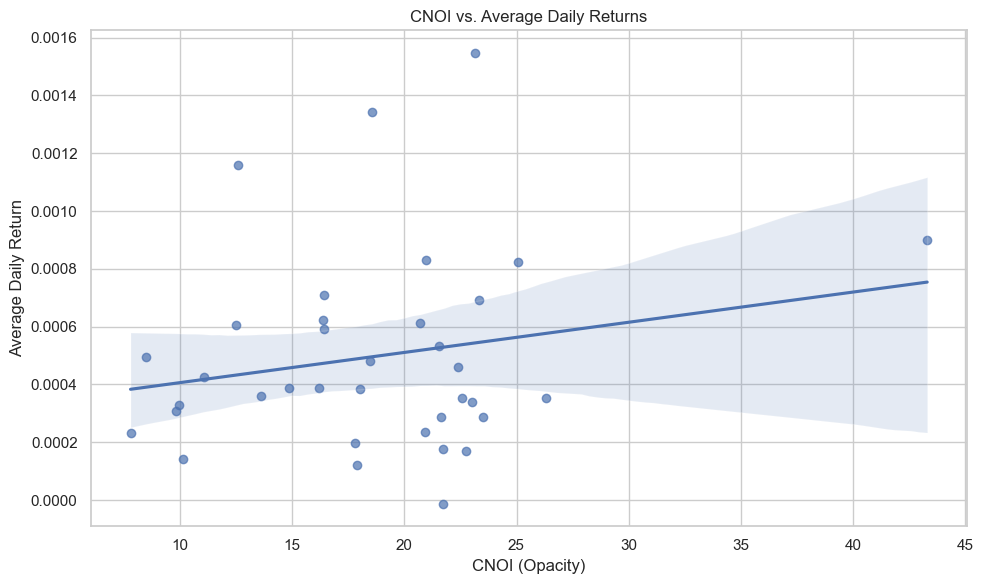

2025-11-08 16:10:26 - notebooks.data_exploration - INFO - Correlation between CNOI and avg daily returns: 0.2039


np.float64(0.20392068456355703)

In [12]:

fig, ax = plt.subplots(figsize=(10, 6))
sns.regplot(data=merged, x="CNOI", y="avg_daily_ret", ax=ax, scatter_kws={"alpha": 0.7})
ax.set_title("CNOI vs. Average Daily Returns")
ax.set_xlabel("CNOI (Opacity)")
ax.set_ylabel("Average Daily Return")
plt.tight_layout()
plt.show()

corr_value = merged[["CNOI", "avg_daily_ret"]].corr().iloc[0, 1]
LOGGER.info("Correlation between CNOI and avg daily returns: %.4f", corr_value)
corr_value


## 11. Persist Processed Datasets

In [13]:

cnoi_output_path = RESULTS_DIR / "cnoi_with_tickers.csv"
market_output_path = RESULTS_DIR / "market_returns.csv"
merged_output_path = RESULTS_DIR / "cnoi_returns_merged.csv"

cnoi_df.to_csv(cnoi_output_path, index=False)
market_df.to_csv(market_output_path, index=False)
merged.to_csv(merged_output_path, index=False)

LOGGER.info("Saved processed datasets to %s", RESULTS_DIR)
{
    "cnoi_path": cnoi_output_path,
    "market_path": market_output_path,
    "merged_path": merged_output_path,
}


2025-11-08 16:10:26 - notebooks.data_exploration - INFO - Saved processed datasets to /Users/nirvanchitnis/ACCT445-Showcase/results


{'cnoi_path': PosixPath('/Users/nirvanchitnis/ACCT445-Showcase/results/cnoi_with_tickers.csv'),
 'market_path': PosixPath('/Users/nirvanchitnis/ACCT445-Showcase/results/market_returns.csv'),
 'merged_path': PosixPath('/Users/nirvanchitnis/ACCT445-Showcase/results/cnoi_returns_merged.csv')}

## 12. Initial Observations

In [14]:

from IPython.display import Markdown
from textwrap import dedent as _dedent

observations = _dedent(
    f"""
    ### Key Takeaways
    - Dataset spans {cnoi_df['issuer'].nunique()} issuers with CNOI between {cnoi_df['CNOI'].min():.2f} and {cnoi_df['CNOI'].max():.2f}.
    - Ticker coverage is {ticker_coverage:.1f}% and {quality_metrics['unique_tickers']} tickers produced {quality_metrics['total_rows']} daily observations.
    - Extreme daily moves (>5%) remain rare (median per ticker = {per_ticker['extreme_moves'].median():.0f}).
    - Correlation between opacity (CNOI) and average daily returns is {corr_value:.3f}, hinting at modest underperformance for opaque filers.
    """
)

Markdown(observations)



### Key Takeaways
- Dataset spans 40 issuers with CNOI between 5.56 and 43.30.
- Ticker coverage is 100.0% and 36 tickers produced 24045 daily observations.
- Extreme daily moves (>5%) remain rare (median per ticker = 16).
- Correlation between opacity (CNOI) and average daily returns is 0.204, hinting at modest underperformance for opaque filers.
